In [1]:
import pickle
import os
import time
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.decomposition import FastICA
from mpl_toolkits.axes_grid1 import ImageGrid
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
import nibabel as nib
import ants
from scipy.ndimage.morphology import binary_erosion
from scipy.ndimage.morphology import binary_dilation
import cv2
import bigbadbrain as bbb
import scipy
from scipy.interpolate import interp1d
from matplotlib.colors import ListedColormap
from matplotlib.pyplot import cm
import matplotlib.colors as mcolors
import matplotlib
import tqdm
import brainsss

/home/users/brezovec/.local/lib/python3.6/site-packages/ants/viz/render_surface_function.py:16: UserWarning: Cant import Plotly. Install it `pip install chart_studio` if you want to use ants.render_surface_function
  "Cant import Plotly. Install it `pip install chart_studio` if you want to use ants.render_surface_function"


In [103]:
cluster_dir = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20221109_cluster_pca/"

In [104]:
### Load Supercluster Signals ###
file = os.path.join(cluster_dir, "20221202_SC_signals.npy")
supercluster_signals = np.load(file)
supercluster_signals.shape

(501, 30456)

In [105]:
file = os.path.join(cluster_dir,"20221122_behavior_fwd.npy")
beh_fwd = np.load(file)
print(beh_fwd.shape)

file = os.path.join(cluster_dir,"20221122_behavior_turn.npy")
beh_turn = np.load(file)
print(beh_turn.shape)

(30456,)
(30456,)


In [106]:
file = os.path.join(cluster_dir, 'superclusters_more.npy')
superclusters = np.load(file)
#with 249 there will be clusters 1-250 inclusive (len=250). cluster 140 is background
superclusters_250 = superclusters[:,:,:,249]
# right brain gets +250 to cluster ID so now 500 clusters
superclusters_250[157:,:,:] += 250

In [107]:
atlas = brainsss.load_roi_atlas()
explosion_rois = brainsss.load_explosion_groups()
all_rois = brainsss.unnest_roi_groups(explosion_rois)
roi_masks = brainsss.make_single_roi_masks(all_rois, atlas)
roi_contours = brainsss.make_single_roi_contours(roi_masks, atlas)

# analysis

### lets first visualize hemi avg corr to clipped turn

In [154]:
corrs_pos_turn = []
for i in range(len(supercluster_signals)):
    X = supercluster_signals[i,:]
    Y = np.clip(beh_turn,0,None)
    r, p = scipy.stats.pearsonr(X, Y)
    corrs_pos_turn.append(r)
    
corrs_neg_turn = []
for i in range(len(supercluster_signals)):
    X = supercluster_signals[i,:]
    Y = np.clip(beh_turn,None,0)*-1
    r, p = scipy.stats.pearsonr(X, Y)
    corrs_neg_turn.append(r)

In [172]:
ipsi_turn_corrs = []
for i in range(250):
    ipsi_turn_corrs.append((corrs_pos_turn[i] + corrs_neg_turn[i+250])/2)

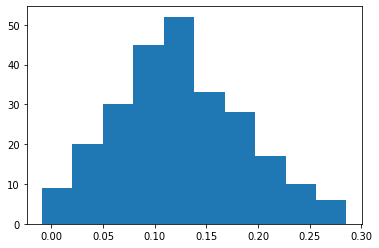

In [173]:
plt.hist(ipsi_turn_corrs);

In [176]:
corr_to_independent_hemi = np.zeros(superclusters_250.shape)
for cluster in range(250):
    ind = np.where(superclusters_250==cluster)
    corr_to_independent_hemi[ind[0],ind[1],ind[2]] = ipsi_turn_corrs[cluster]

In [134]:
# empty1 = np.zeros(superclusters_250.shape)
# for cluster in range(501):
#     ind = np.where(superclusters_250==cluster)
#     empty1[ind[0],ind[1],ind[2]] = corrs_pos_turn[cluster]
    
# empty2 = np.zeros(superclusters_250.shape)
# for cluster in range(501):
#     ind = np.where(superclusters_250==cluster)
#     empty2[ind[0],ind[1],ind[2]] = corrs_neg_turn[cluster]
    
# corr_to_independent_hemi = (empty1+empty2[::-1,:,:])/2

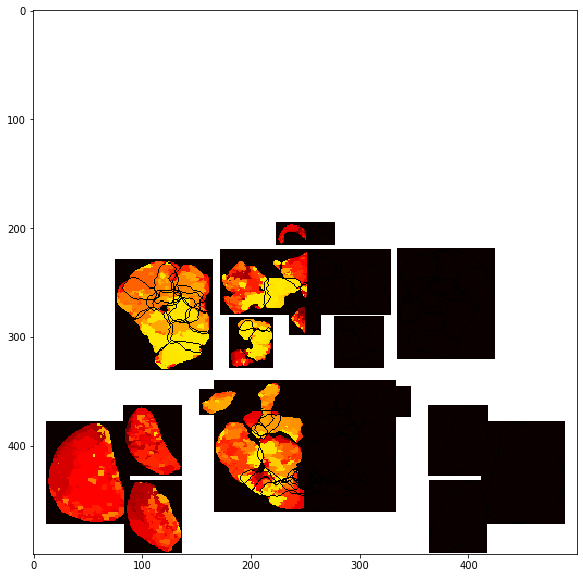

In [177]:
data_to_plot = corr_to_independent_hemi
input_canvas = np.ones((500,500,3))
vmax = .4

explosion_map = brainsss.place_roi_groups_on_canvas(explosion_rois,
                                                    roi_masks,
                                                    roi_contours,
                                                    data_to_plot,
                                                    input_canvas,
                                                    vmax=vmax,
                                                    cmap='hot',
                                                    diverging=False)#'hot')

plt.figure(figsize=(10,10))
plt.imshow(explosion_map)

### now lets visualize hemi diff corr to turning

In [178]:
supercluster_signals_difference = []
for i in range(250):
    supercluster_signals_difference.append(supercluster_signals[i,:] - supercluster_signals[i+250,:])

In [187]:
corrs_diff = []
for i in range(len(supercluster_signals_difference)):
    X = supercluster_signals_difference[i]
    Y = beh_turn
    r, p = scipy.stats.pearsonr(X, Y)
    corrs_diff.append(r)

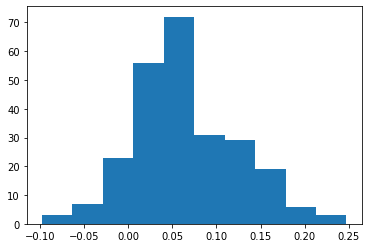

In [188]:
plt.hist(corrs_diff);

In [195]:
corr_to_diff = np.zeros(superclusters_250.shape)
for cluster in range(250):
    ind = np.where(superclusters_250==cluster)
    corr_to_diff[ind[0],ind[1],ind[2]] = corrs_diff[cluster]

In [191]:
corr_to_diff = np.clip(corr_to_diff*-1,0,None)

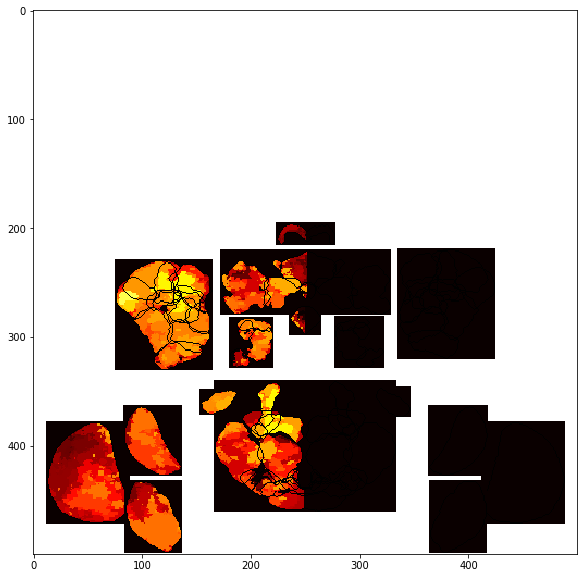

In [198]:
data_to_plot = corr_to_diff
input_canvas = np.ones((500,500,3))
vmax = .3

explosion_map = brainsss.place_roi_groups_on_canvas(explosion_rois,
                                                    roi_masks,
                                                    roi_contours,
                                                    data_to_plot,
                                                    input_canvas,
                                                    vmax=vmax,
                                                    cmap='hot',
                                                    diverging=False)#'hot')

plt.figure(figsize=(10,10))
plt.imshow(explosion_map)

### finally lets do diff between independent hemis and diff hemi corrs

In [202]:
diff_of_diff = []
for cluster in range(250):
    diff_of_diff.append(corrs_diff[cluster]-ipsi_turn_corrs[cluster])

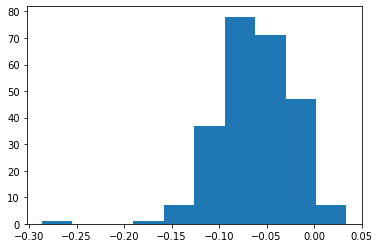

In [203]:
plt.hist(diff_of_diff);

In [209]:
corr_to_diff = np.zeros(superclusters_250.shape)
for cluster in range(250):
    ind = np.where(superclusters_250==cluster)
    corr_to_diff[ind[0],ind[1],ind[2]] = diff_of_diff[cluster]

In [207]:
corr_to_diff = np.clip(corr_to_diff,0,None)

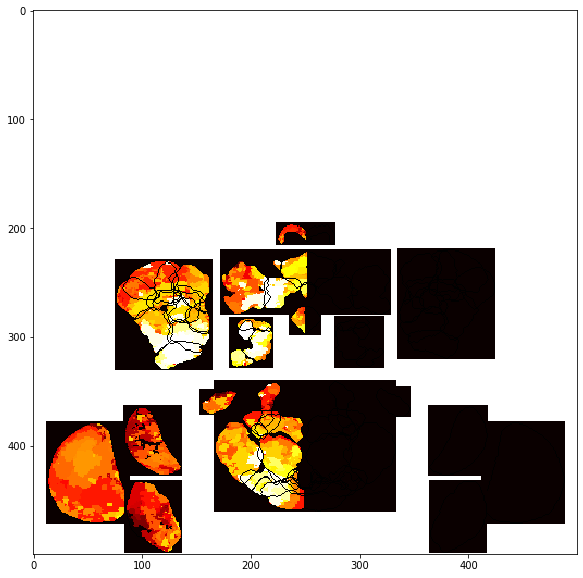

In [210]:
data_to_plot = corr_to_diff*-1
input_canvas = np.ones((500,500,3))
vmax = .15

explosion_map = brainsss.place_roi_groups_on_canvas(explosion_rois,
                                                    roi_masks,
                                                    roi_contours,
                                                    data_to_plot,
                                                    input_canvas,
                                                    vmax=vmax,
                                                    cmap='hot',
                                                    diverging=False)#'hot')

plt.figure(figsize=(10,10))
plt.imshow(explosion_map)

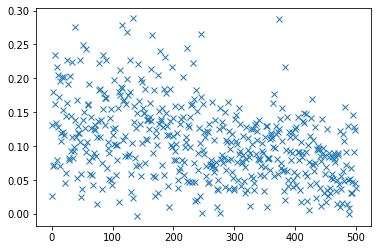

In [8]:
plt.plot(corrs,'x')

In [123]:
idx = np.argsort(np.nan_to_num(corrs))[::-1][0]

In [133]:
185+250

435

Text(0, 0.5, 'cluster activity')

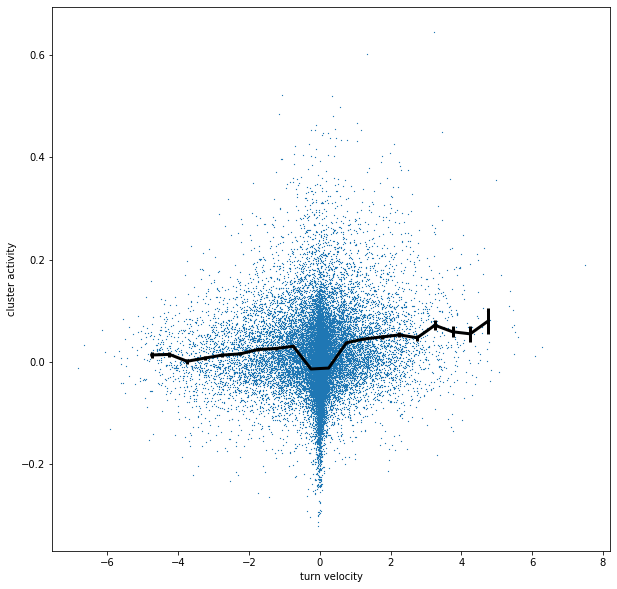

In [160]:
idx = 47
plt.figure(figsize=(10,10))
plt.scatter(beh_turn,supercluster_signals[idx,:],marker='x',s=.1)

# make x bins, get mean y in each bin
num_bins = 20
xbins = np.linspace(-5,5,num_bins+1)
step = xbins[1] - xbins[0]
mids = [i+step/2 for i in xbins]
avgs = []
stds = []
cnts = []
for i in range(num_bins):
    start = xbins[i]
    end = xbins[i+1]
    a = np.where(np.logical_and(beh_turn>start, beh_turn<=end))
    avgs.append(np.mean(supercluster_signals[idx,:][a]))
    stds.append(np.std(supercluster_signals[idx,:][a]))
    cnts.append(len(a[0]))

#plt.scatter(behavior_super[beh],supercluster_signals[neu],marker='.',color='grey',s=1)

### Plot line along bins, with error bar ###
sem = [stds[i]/np.sqrt(cnts[i]) for i in range(len(mids)-1)]
plt.errorbar(mids[:-1], avgs, yerr=sem, label='both limits (default)',color='k',lw=3)

plt.xlabel('turn velocity')
plt.ylabel('cluster activity')

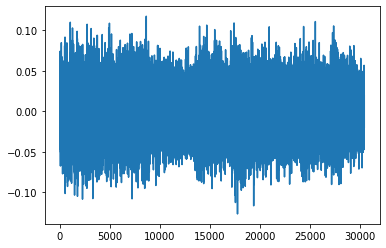

In [115]:
plt.plot(supercluster_signals_difference[134])

Text(0, 0.5, 'cluster activity')

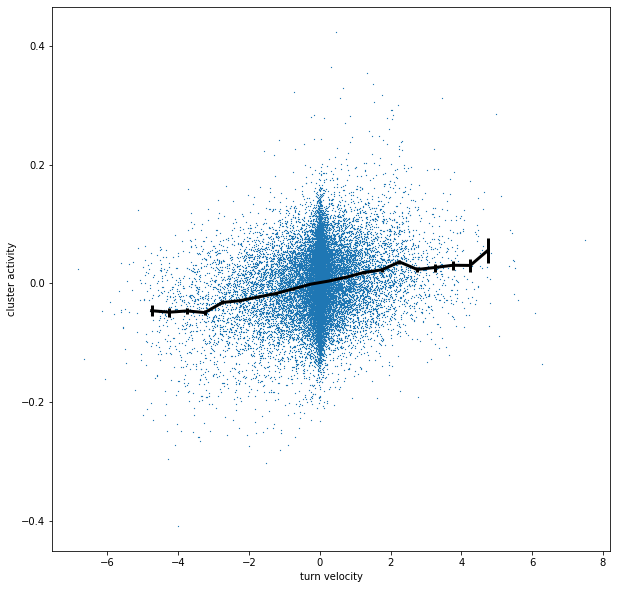

In [159]:
idx = 47
plt.figure(figsize=(10,10))
plt.scatter(beh_turn,supercluster_signals_difference[idx],marker='x',s=.1)

# make x bins, get mean y in each bin
num_bins = 20
xbins = np.linspace(-5,5,num_bins+1)
step = xbins[1] - xbins[0]
mids = [i+step/2 for i in xbins]
avgs = []
stds = []
cnts = []
for i in range(num_bins):
    start = xbins[i]
    end = xbins[i+1]
    a = np.where(np.logical_and(beh_turn>start, beh_turn<=end))
    avgs.append(np.mean(supercluster_signals_difference[idx][a]))
    stds.append(np.std(supercluster_signals_difference[idx][a]))
    cnts.append(len(a[0]))

#plt.scatter(behavior_super[beh],supercluster_signals[neu],marker='.',color='grey',s=1)

### Plot line along bins, with error bar ###
sem = [stds[i]/np.sqrt(cnts[i]) for i in range(len(mids)-1)]
plt.errorbar(mids[:-1], avgs, yerr=sem, label='both limits (default)',color='k',lw=3)

plt.xlabel('turn velocity')
plt.ylabel('cluster activity')

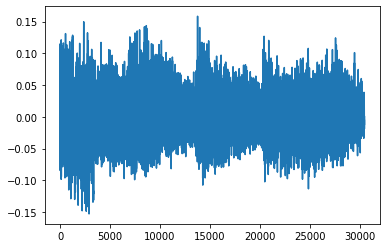

In [90]:
idx = np.argsort(corrs)[::-1][0]
plt.plot(supercluster_signals[idx,:]*10)
plt.plot(beh_turn)
plt.xlim(5000,)

(array([10., 20., 35., 41., 52., 37., 24., 18.,  7.,  6.]),
 array([-0.00313371,  0.02603708,  0.05520787,  0.08437866,  0.11354945,
         0.14272024,  0.17189103,  0.20106182,  0.23023261,  0.2594034 ,
         0.28857419]),
 <a list of 10 Patch objects>)

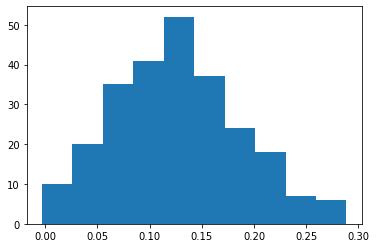

In [57]:
plt.hist(corrs[:250])

In [39]:
supercluster_signals.shape

(501, 30456)

In [58]:
supercluster_signals_difference = []
for i in range(250):
    supercluster_signals_difference.append(supercluster_signals[i] - supercluster_signals[i+250])

In [63]:
corrs_diff = []
for i in range(len(supercluster_signals_difference)):
    X = supercluster_signals_difference[i]
    Y = beh_turn
    #Y = np.clip(beh_turn,0,None)
    r, p = scipy.stats.pearsonr(X, Y)
    corrs_diff.append(r)

(array([ 3.,  7., 23., 56., 72., 31., 29., 19.,  6.,  3.]),
 array([-0.09751315, -0.06303762, -0.02856208,  0.00591346,  0.04038899,
         0.07486453,  0.10934007,  0.1438156 ,  0.17829114,  0.21276668,
         0.24724221]),
 <a list of 10 Patch objects>)

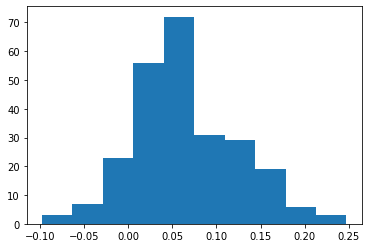

In [64]:
plt.hist(corrs_diff)

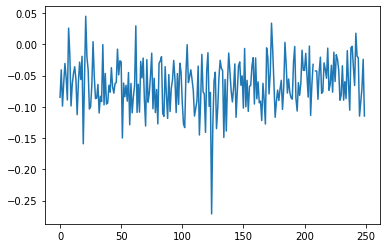

In [142]:
plt.plot([corrs_diff[i]-corrs[i] for i in range(250)])

In [153]:
temp = np.nan_to_num([corrs_diff[i]-corrs[i] for i in range(250)])
np.argmax(temp)

21

In [31]:
len(ind[0])

385

In [82]:
empty = np.zeros(superclusters_250.shape)
for cluster in range(250):
    ind = np.where(superclusters_250==cluster)
    empty[ind[0],ind[1],ind[2]] = 1/(1+len(ind[0]))#corrs_diff[cluster]/len(ind[0])

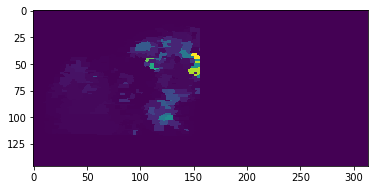

In [83]:
plt.imshow(empty[:,:,40].T)

In [84]:
np.max(np.nan_to_num(empty))

0.2

In [85]:
data_to_plot = empty

In [89]:
input_canvas = np.ones((500,500,3))
vmax = .01

In [90]:
explosion_map = brainsss.place_roi_groups_on_canvas(explosion_rois,
                                                    roi_masks,
                                                    roi_contours,
                                                    data_to_plot,
                                                    input_canvas,
                                                    vmax=vmax,
                                                    cmap='hot',
                                                   diverging=False)#'hot')

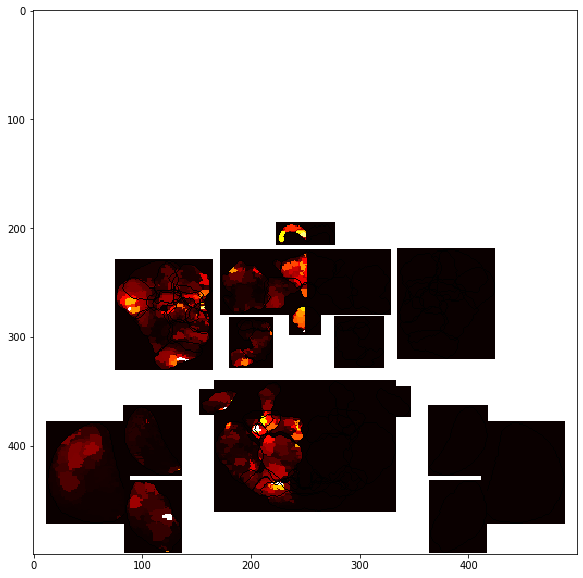

In [91]:
plt.figure(figsize=(10,10))
plt.imshow(explosion_map)

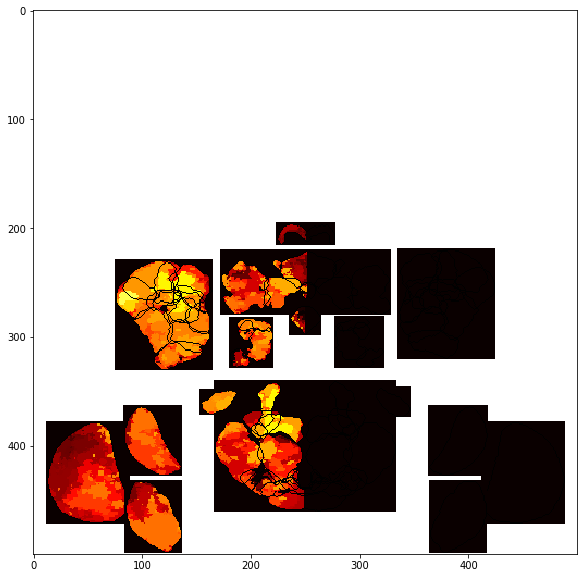

In [50]:
plt.figure(figsize=(10,10))
plt.imshow(explosion_map)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


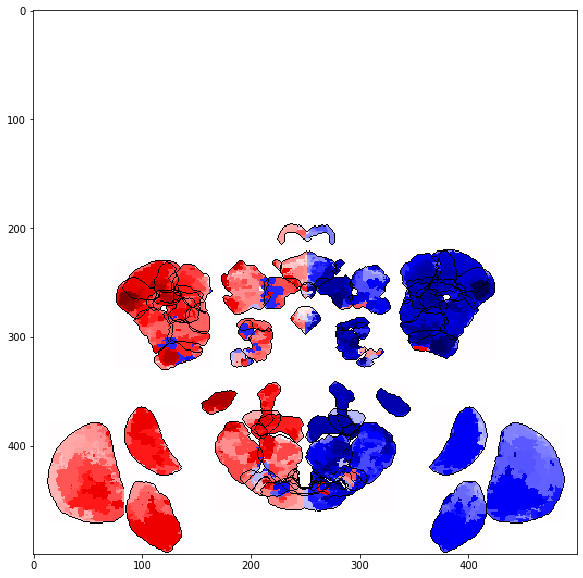

In [28]:
plt.figure(figsize=(10,10))
plt.imshow(explosion_map)

# Lets look at single voxel resolution

In [ ]:
# do we have any source for the neural data in the mirror symmetric space?
# what about data for Feng?

# i dont think it exists
# so, easiest may be to use supervoxels in OG space to get signals
# or maybe I should warp all raw data into FDA space... Yep.

In [ ]:
### I warped in sherlock. Lets

In [4]:
dataset_path = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190101_walking_dataset"
flies = ['fly_087', 'fly_089', 'fly_094', 'fly_095', 'fly_097', 'fly_098', 'fly_099', 'fly_100', 'fly_101', 'fly_105']

In [5]:
fly = flies[0]
file = os.path.join(dataset_path, fly, 'func_0', 'brain_zscored_green_high_pass_masked_warped_to_FDA.nii')
brain = ants.image_read(file)
brain.shape

(314, 146, 91, 3384)

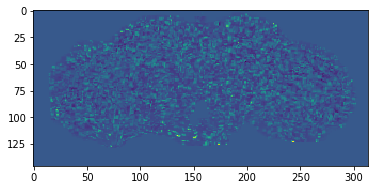

In [8]:
plt.imshow(brain[:,:,70,100].T)

In [ ]:
### should I subtract hemis then make corr to turn diff? yes.

In [13]:
brain_diff = brain[:157,:,:,:] - brain[-157:,:,:,:][::-1,...]

In [15]:
brain_diff.shape

(157, 146, 91, 3384)

In [19]:
corrs = []
for x in tqdm.tqdm(range(157)):
    for y in range(146):
        for z in range(91):
            X = brain_diff[x,y,z]
            Y = beh_turn[:3384]
            r, p = scipy.stats.pearsonr(X, Y)
            corrs.append(r)

100%|██████████| 157/157 [04:37<00:00,  1.77s/it]


In [20]:
corrs = np.asarray(corrs)
corrs = np.reshape(corrs,(157,146,91))

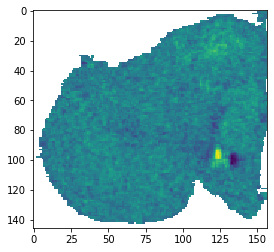

In [25]:
plt.imshow(corrs[:,:,50].T)

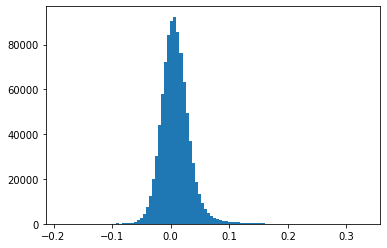

In [49]:
plt.hist(corrs.flatten(),bins=100);

In [71]:
data_to_plot = np.zeros((314,146,91))
data_to_plot[:157,...] = np.nan_to_num(corrs)

In [67]:
data_to_plot.shape

(314, 146, 91)

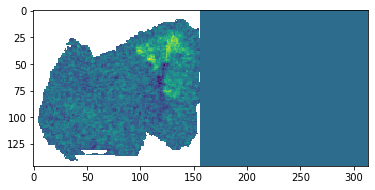

In [68]:
plt.imshow(data_to_plot[:,:,40].T)

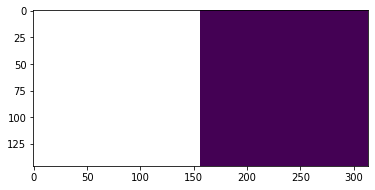

In [69]:
plt.imshow(np.max(data_to_plot,axis=2).T)

In [78]:
input_canvas = np.ones((500,500,3))+.5
vmax = .2

In [79]:
explosion_map = brainsss.place_roi_groups_on_canvas(explosion_rois,
                                                    roi_masks,
                                                    roi_contours,
                                                    data_to_plot,
                                                    input_canvas,
                                                    vmax=vmax,
                                                    cmap='seismic',
                                                    diverging=True)#'hot')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


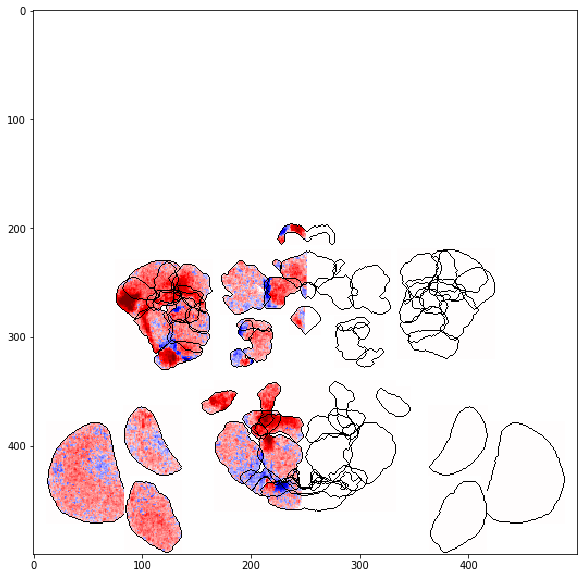

In [80]:
plt.figure(figsize=(10,10))
plt.imshow(explosion_map)

# look at sasha style L vs R

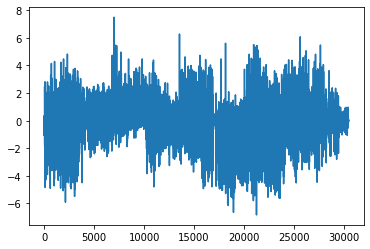

In [37]:
plt.plot(beh_turn)

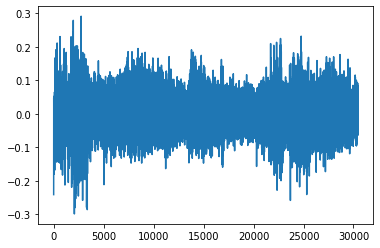

In [39]:
plt.plot(x_data)

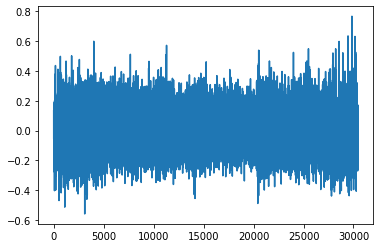

In [40]:
plt.plot(y_data)

Text(0.5, 0.72, 'Clusters 124, 374')

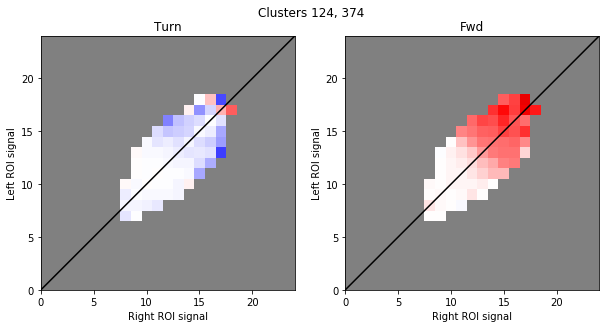

In [32]:
plt.figure(figsize=(10,10))

cluster_ = 124

x_data = supercluster_signals[cluster_,:]
y_data = supercluster_signals[cluster_+250,:]
behavior = beh_turn

for k,(behavior,title) in enumerate(zip([beh_turn, beh_fwd],['Turn','Fwd'])):
    plt.subplot(1,2,k+1)
    start=-0.4
    stop=0.4
    num_bins=25
    min_num_samples=10

    # Define bins
    bins = np.linspace(start,stop,num_bins)

    # Assign neural values to bin numbers
    idx_x, idx_y = np.digitize(x_data,bins), np.digitize(y_data,bins)

    binned_signal = []
    sample_count = []
    for i in range(num_bins):
        mask_x = (idx_x == i)
        for j in range(num_bins):
            mask_y = (idx_y == j)
            mask = mask_x & mask_y

            binned_signal.append(np.mean(behavior[mask]))
            sample_count.append(np.count_nonzero(~np.isnan(behavior[mask])))

    binned_signal = np.reshape(binned_signal,(num_bins, num_bins))
    sample_count = np.reshape(sample_count,(num_bins, num_bins))

    # Hide bins containing too few data points
    binned_signal[np.where(sample_count<=min_num_samples)] = np.nan

    cmap = plt.cm.get_cmap("seismic")
    cmap.set_bad(color='grey')
    plt.imshow(binned_signal,vmin=-3,vmax=3,cmap=cmap,origin='lower')
    plt.ylabel('Left ROI signal')
    plt.xlabel('Right ROI signal')
    plt.plot([0,25],[0,25],color='k')
    #plt.colorbar()
    plt.ylim(0,24)
    plt.xlim(0,24)
    plt.title(title)
plt.suptitle(F"Clusters {cluster_}, {cluster_+250}",y=.72)

In [85]:
binned_signal = np.reshape(binned_signal,(num_bins, num_bins))

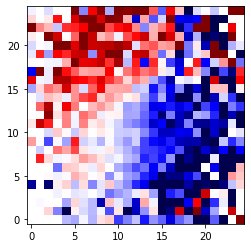

In [52]:
plt.imshow(binned_signal,vmin=-.5,vmax=.5,cmap='seismic',origin='lower')

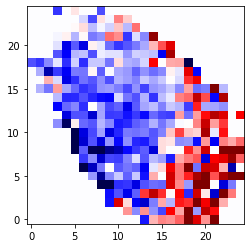

In [20]:
plt.imshow(binned_signal,vmin=-.5,vmax=.5,cmap='seismic',origin='lower')


In [128]:
dir_ = "/oak/stanford/groups/trc/data/Alex/clab_data/DSX/anat/raw"
os.listdir(dir_)

['201204_03_red.nii',
 '201206_02_red.nii',
 '201113_04_red.nii',
 '201106_03_red.nii',
 '201113_01_red.nii',
 '210202_01_red.nii',
 '210128_02_red.nii',
 '210128_04_red.nii',
 '201113_02_red.nii',
 '201113_03_red.nii',
 '210202_02_red.nii',
 '201106_02_red.nii']

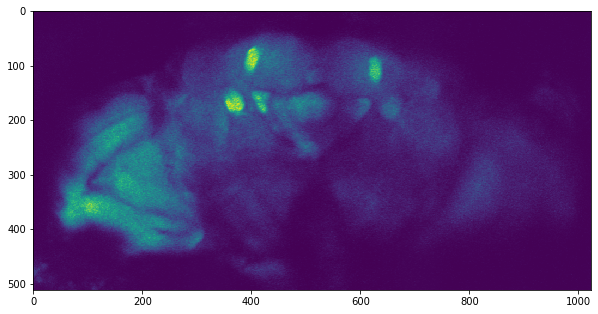

In [119]:
os.mkdir("/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20230124_DSX_meanbrain/clandinin/raw_anats")

In [121]:
import shutil

In [125]:
moving_dir = "/oak/stanford/groups/trc/data/Alex/albert_data/DSX/anat/raw2"
dest_dir = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20230124_DSX_meanbrain/murthy/raw_anats"
for file in os.listdir(moving_dir):
    print(file)
    src = os.path.join(moving_dir,file)
    dst = os.path.join(dest_dir,file)
    shutil.copyfile(src, dst)

220408_dsx_vol1_local_atlas_red.nii
220605_dsx_vol3_local_atlas_red.nii
220616_dsx_vol2_local_atlas_red.nii
221108_dsx_vol1_local_atlas_red.nii
220616_dsx_vol1_local_atlas_red.nii
220422_dsx_vol1_local_atlas_red.nii
220604_dsx_vol1_local_atlas_red.nii
220605_dsx_vol2_local_atlas_red.nii


In [176]:

file = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20230124_DSX_meanbrain/clandinin/raw_anats/201204_03_red.nii"
file2 = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20230124_DSX_meanbrain/clandinin/201204_03_red.nii"
shutil.copyfile(file, file2)

'/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20230124_DSX_meanbrain/clandinin/201204_03_red.nii'

In [9]:
dir_ = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20230124_DSX_meanbrain/clandinin/affine_0"
os.listdir(dir_)

['201113_01_red_clean-to-201204_03_red.nii',
 '210202_02_red_clean-to-201204_03_red.nii',
 '210128_04_red_clean-to-201204_03_red.nii',
 '201206_02_red_clean_m-to-201204_03_red.nii',
 '201204_03_red_clean_m-to-201204_03_red.nii',
 '210202_02_red_clean_m-to-201204_03_red.nii',
 '201206_02_red_clean-to-201204_03_red.nii',
 '210202_01_red_clean-to-201204_03_red.nii',
 '201113_02_red_clean_m-to-201204_03_red.nii',
 '201113_04_red_clean-to-201204_03_red.nii',
 '210202_01_red_clean_m-to-201204_03_red.nii',
 '201106_02_red_clean-to-201204_03_red.nii',
 '201204_03_red_clean-to-201204_03_red.nii',
 '201106_03_red_clean_m-to-201204_03_red.nii',
 '201113_04_red_clean_m-to-201204_03_red.nii',
 '210128_04_red_clean_m-to-201204_03_red.nii',
 '201106_03_red_clean-to-201204_03_red.nii',
 '210128_02_red_clean-to-201204_03_red.nii',
 '201113_03_red_clean_m-to-201204_03_red.nii',
 '201113_02_red_clean-to-201204_03_red.nii',
 '201113_01_red_clean_m-to-201204_03_red.nii',
 '201106_02_red_clean_m-to-201204_0

In [11]:
def load_numpy_brain(in_file):
    if in_file.endswith('.nii'):
        brain = np.asarray(nib.load(in_file).get_data().squeeze(), dtype='float32')
    elif in_file.endswith('.nrrd'):
        brain = np.asarray(nrrd.read(in_file)[0].squeeze(), dtype='float32')
    else:
        print(f'Could not load {in_file}')
    return brain

def avg_brains(input_directory):
    ### Load Brains ###
    files = os.listdir(input_directory)
    bigbrain = np.zeros((len(files), 1024, 512, 241), dtype='float32',order='F') #my brain size
    #bigbrain = np.zeros((len(files), 333, 166, 121), dtype='float32',order='F') # should add code to get dims
    for i, file in enumerate(files):
        print(F"loading {file}")
        bigbrain[i,...] = load_numpy_brain(os.path.join(input_directory, file))
        #bigbrain[i,...] = np.asarray(nib.load(os.path.join(input_directory, file)).get_data(), dtype='float32')

    ### Avg ###
    meanbrain = np.mean(bigbrain, axis=0)
    return meanbrain

In [12]:
input_directory = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20230124_DSX_meanbrain/clandinin/affine_0"
meanbrain = avg_brains(input_directory)

loading 201113_01_red_clean-to-201204_03_red.nii
loading 210202_02_red_clean-to-201204_03_red.nii
loading 210128_04_red_clean-to-201204_03_red.nii
loading 201206_02_red_clean_m-to-201204_03_red.nii
loading 201204_03_red_clean_m-to-201204_03_red.nii
loading 210202_02_red_clean_m-to-201204_03_red.nii
loading 201206_02_red_clean-to-201204_03_red.nii
loading 210202_01_red_clean-to-201204_03_red.nii
loading 201113_02_red_clean_m-to-201204_03_red.nii
loading 201113_04_red_clean-to-201204_03_red.nii
loading 210202_01_red_clean_m-to-201204_03_red.nii
loading 201106_02_red_clean-to-201204_03_red.nii
loading 201204_03_red_clean-to-201204_03_red.nii
loading 201106_03_red_clean_m-to-201204_03_red.nii
loading 201113_04_red_clean_m-to-201204_03_red.nii
loading 210128_04_red_clean_m-to-201204_03_red.nii
loading 201106_03_red_clean-to-201204_03_red.nii
loading 210128_02_red_clean-to-201204_03_red.nii
loading 201113_03_red_clean_m-to-201204_03_red.nii
loading 201113_02_red_clean-to-201204_03_red.nii
lo

In [13]:
meanbrain.shape

(1024, 512, 241)

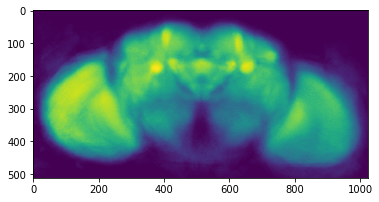

In [18]:
plt.imshow(meanbrain[:,:,150].T)

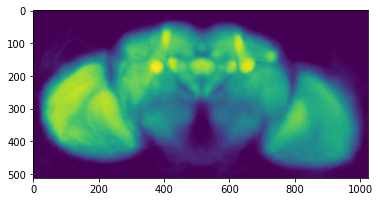

In [25]:
plt.imshow(brain[:,:,150].T)

In [8]:
brain = ants.image_read("/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20230124_DSX_meanbrain/clandinin/syn_6.nii")

In [78]:
os.mkdir("/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20230127_DSX_to_local/clandinin")

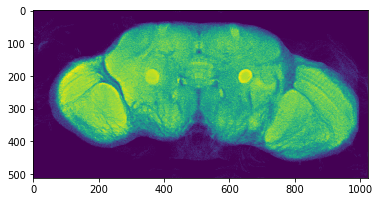

In [12]:
plt.imshow(brain[:,:,100].T)

In [14]:
os.listdir("/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20230124_DSX_meanbrain/murthy/raw_anats")

['220408_dsx_vol1_local_atlas_red.nii',
 '220605_dsx_vol3_local_atlas_red.nii',
 '220616_dsx_vol2_local_atlas_red.nii',
 '221108_dsx_vol1_local_atlas_red.nii',
 '220616_dsx_vol1_local_atlas_red.nii',
 '220422_dsx_vol1_local_atlas_red.nii',
 '220604_dsx_vol1_local_atlas_red.nii',
 '220605_dsx_vol2_local_atlas_red.nii']

In [73]:
dir_ = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20230124_DSX_meanbrain/murthy/raw_anats"
for file in os.listdir(dir_):
    brain = ants.image_read(os.path.join(dir_, file))
    print(brain.shape)

(1024, 512, 249)
(1024, 512, 299)
(1024, 512, 299)
(1024, 512, 299)
(1024, 512, 299)
(1024, 512, 299)
(1024, 512, 299)


In [74]:
brain = ants.image_read(os.path.join(dir_, '220408_dsx_vol1_local_atlas_red.nii'))
brain.shape

(1024, 512, 249)

In [80]:
pad = np.zeros((1024,512,50))
out = np.concatenate((brain.numpy(),pad),axis=2)
out.shape

(1024, 512, 299)

In [81]:
save_file = os.path.join(dir_, '220408_dsx_vol1_local_atlas_red.nii')
nib.Nifti1Image(out, np.eye(4)).to_filename(save_file)

In [78]:
pad.shape

(1024, 512, 50)

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(brain[:,:,110].T)

In [72]:
brain.shape

(1024, 512, 299)

In [ ]:
### lets look at mean green channel for direct warps to DSX

In [95]:
dir_ = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20221029_FDA_direct_syn_DSX/clandinin"
brains = []
for file in os.listdir(dir_):
    if 'green' in file:
        print(file)
        brains.append(ants.image_read(os.path.join(dir_, file)).numpy())

210202_01_green-to-FDA.nii
201113_02_green-to-FDA.nii
201106_02_green-to-FDA.nii
201204_03_green-to-FDA.nii
201113_04_green-to-FDA.nii
201113_03_green-to-FDA.nii
201113_01_green-to-FDA.nii
210128_02_green-to-FDA.nii
201206_02_green-to-FDA.nii
210128_04_green-to-FDA.nii
201106_03_green-to-FDA.nii
210202_02_green-to-FDA.nii


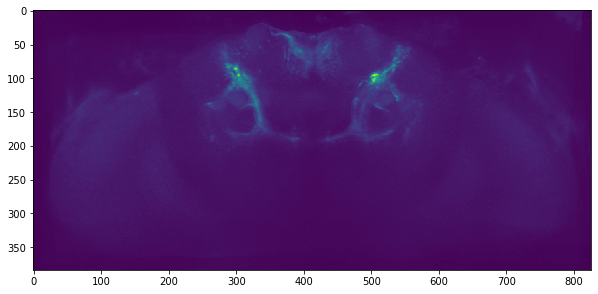

In [94]:
#mean
plt.figure(figsize=(10,10))
plt.imshow(brain[:,:,120].T)

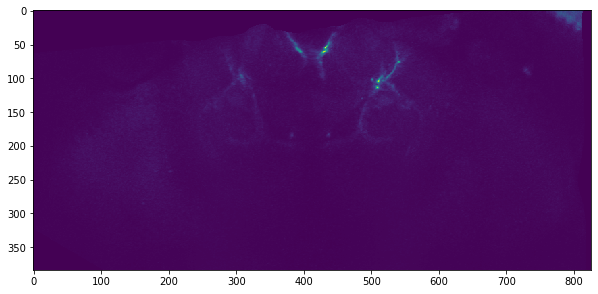

In [102]:
plt.figure(figsize=(10,10))
plt.imshow(brains[6][:,:,120].T)

In [13]:
file = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20230124_DSX_meanbrain/murthy/syn_6.nii"
brain = ants.image_read(file)

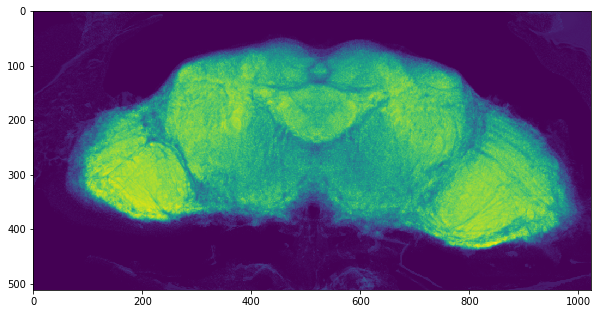

In [12]:
plt.figure(figsize=(10,10))
plt.imshow(brain[:,:,80].T)

In [16]:
file = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20230124_DSX_meanbrain/murthy/clanDSXmean-to-FDA.nii"
brain = ants.image_read(file)

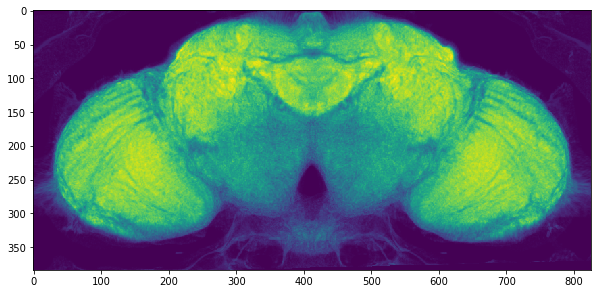

In [17]:
plt.figure(figsize=(10,10))
plt.imshow(brain[:,:,80].T)

In [19]:
os.mkdir("/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20230124_DSX_meanbrain/murthy_hybrid/raw_anats")

In [21]:
import shutil

In [22]:
src_dir = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20230124_DSX_meanbrain/murthy/raw_anats"
dest_dir = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20230124_DSX_meanbrain/murthy_hybrid/raw_anats"
for file in os.listdir(src_dir):
    print(file)
    src = os.path.join(src_dir,file)
    dst = os.path.join(dest_dir,file)
    shutil.copyfile(src, dst)

220408_dsx_vol1_local_atlas_red.nii
220605_dsx_vol3_local_atlas_red.nii
220616_dsx_vol2_local_atlas_red.nii
221108_dsx_vol1_local_atlas_red.nii
220422_dsx_vol1_local_atlas_red.nii
220604_dsx_vol1_local_atlas_red.nii
220605_dsx_vol2_local_atlas_red.nii


In [68]:
src_dir = "/oak/stanford/groups/trc/data/Alex/albert_data/LC11/anat/raw"
dest_dir = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20230124_DSX_meanbrain/murthy_hybrid/raw_anats"
for file in os.listdir(src_dir):
    print(file)
    src = os.path.join(src_dir,file)
    dst = os.path.join(dest_dir,file)
    shutil.copyfile(src, dst)

220426_LC11_vol2_local_atlas_red.nii
220412_LC11_vol1_local_atlas_red.nii
220425_LC11_vol1_local_atlas_red.nii
220420_LC11_vol2_local_atlas_red.nii
220426_LC11_vol1_local_atlas_red.nii
220420_LC11_vol1_local_atlas_red.nii
skip
220413_LC11_vol1_local_atlas_red.nii
220419_LC11_vol2_local_atlas_red.nii


In [23]:
file = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20230124_DSX_meanbrain/murthy_hybrid/raw_anats/220605_dsx_vol2_local_atlas_red.nii"
brain = ants.image_read(file)
brain.shape

(1024, 512, 299)

In [25]:
file = "/oak/stanford/groups/trc/data/Alex/clab_data/LC11/anat/raw/210216_04_red.nii"
brain = ants.image_read(file)
brain.shape

(1024, 512, 241)

In [69]:
src_dir = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20230124_DSX_meanbrain/murthy_hybrid/raw_anats"
os.listdir(src_dir)

['220426_LC11_vol2_local_atlas_red.nii',
 '220408_dsx_vol1_local_atlas_red.nii',
 '220412_LC11_vol1_local_atlas_red.nii',
 '220605_dsx_vol3_local_atlas_red.nii',
 '220425_LC11_vol1_local_atlas_red.nii',
 '220616_dsx_vol2_local_atlas_red.nii',
 '220420_LC11_vol2_local_atlas_red.nii',
 '220426_LC11_vol1_local_atlas_red.nii',
 '221108_dsx_vol1_local_atlas_red.nii',
 '220420_LC11_vol1_local_atlas_red.nii',
 '220422_dsx_vol1_local_atlas_red.nii',
 '220604_dsx_vol1_local_atlas_red.nii',
 '220605_dsx_vol2_local_atlas_red.nii',
 '220413_LC11_vol1_local_atlas_red.nii',
 '220419_LC11_vol2_local_atlas_red.nii']

In [ ]:
#delete 220420_LC11_vol1_local_atlas_red.nii

In [ ]:
#220425_LC11_vol1_local_atlas_red.nii

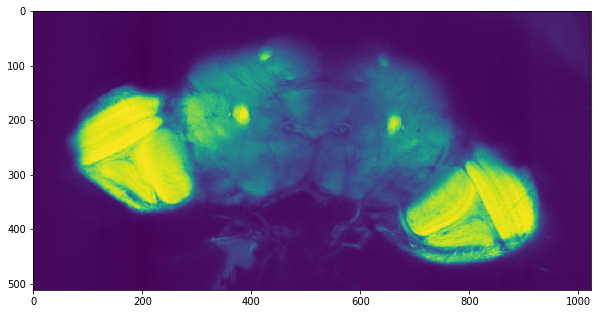

In [75]:
file = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20230124_DSX_meanbrain/murthy_hybrid/raw_anats/220419_LC11_vol2_local_atlas_red.nii"
brain = ants.image_read(file)
plt.figure(figsize=(10,10))
plt.imshow(brain[:,:,100].T)

In [76]:
brain.shape

(1024, 512, 299)

In [23]:
file = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20230124_DSX_meanbrain/murthy_hybrid/syn_5.nii"
brain = ants.image_read(file)

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(brain[:,:,80].T)

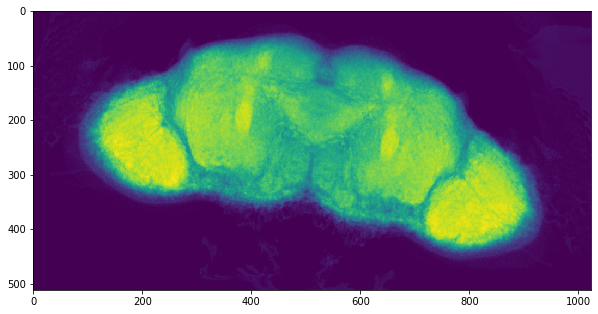

In [18]:
plt.figure(figsize=(10,10))
plt.imshow(brain[:,:,80].T)

In [84]:
### Warp green channels into FDA via 
    #1) localmean
    #2) meantoFDA

In [19]:
os.mkdir("/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20230127_DSX_to_local/murthy")

In [24]:
os.listdir("/oak/stanford/groups/trc/data/Alex/albert_data/DSX/anat/raw2")

['220408_dsx_vol1_local_atlas_red.nii',
 '220605_dsx_vol3_local_atlas_red.nii',
 '220616_dsx_vol2_local_atlas_red.nii',
 '221108_dsx_vol1_local_atlas_red.nii',
 '220616_dsx_vol1_local_atlas_red.nii',
 '220422_dsx_vol1_local_atlas_red.nii',
 '220604_dsx_vol1_local_atlas_red.nii',
 '220605_dsx_vol2_local_atlas_red.nii']

In [26]:
path = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20230130_LC11_full_analysis/meanbrain_building/murthy/raw_anats/"

In [27]:
os.listdir(path)

['220426_LC11_vol2_local_atlas_red.nii',
 '220412_LC11_vol1_local_atlas_red.nii',
 '220425_LC11_vol1_local_atlas_red.nii',
 '220420_LC11_vol2_local_atlas_red.nii',
 '220426_LC11_vol1_local_atlas_red.nii',
 '220420_LC11_vol1_local_atlas_red.nii',
 '220413_LC11_vol1_local_atlas_red.nii',
 '220419_LC11_vol2_local_atlas_red.nii']

In [30]:
brain = ants.image_read(os.path.join(path, "220419_LC11_vol2_local_atlas_red.nii"))
brain.shape

(1024, 512, 299)

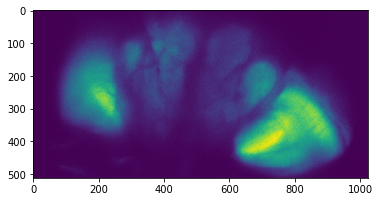

In [29]:
plt.imshow(brain[:,:,240].T)

In [2]:
path = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20230130_LC11_full_analysis/meanbrain_building/clandinin/"
os.listdir(path)

['affine_0.nii',
 'affine_1',
 'affine_1.nii',
 'clean_anats',
 '210216_02_red.nii',
 'syn_2_sharp.nii',
 'syn_1.nii',
 'syn_1',
 'syn_3',
 'syn_0.nii',
 'affine_0',
 'raw_anats',
 'sharp_anats',
 'syn_0',
 'syn_2',
 'syn_2.nii']

In [3]:
brain = ants.image_read(os.path.join(path,"syn_2.nii"))
brain

ANTsImage (LPI)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (1024, 512, 241)
	 Spacing    : (1.0, 1.0, 1.0)
	 Origin     : (0.0, 0.0, 0.0)
	 Direction  : [-1.  0.  0.  0. -1.  0.  0.  0.  1.]

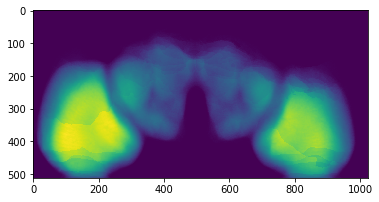

In [9]:
plt.imshow(brain[:,:,200].T)